# Тестовое задание - анализ данных

Организация выдает займы физическим лицам.

Информация о ранее выданных организацией займах в файле [new_training_data_31_08_2022.csv](https://dl.dropboxusercontent.com/s/6tg4aa9kt1y3dar/new_training_data_31_08_2022.csv)

Файл  [all_reject_data.csv](https://dl.dropboxusercontent.com/s/tnvo43de29nu1rb/all_reject_data.csv) содержит данные о клиентах, оставлявших заявки на займ, но в итоге не взявших его по причине отказа финансовой организации или нежеланию самого клиента.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

|Название файла|Описание|
|:-------|:--------|
|`new_training_data_31_08_2022.csv ` |Информация о ранее выданных организацией займах|
|`all_reject_data.csv` | Данные о клиентах, оставлявших заявки на займ, но в итоге не взявших его по причине отказа финансовой организации или нежеланию самого клиента.|


### Необходимо:
1. Выполнить анализ и охарактеризовать клиентский портфель организации.
2. Построить базовую модель прогнозирования банкротства, одобряющую не менее 35% клиентов при банкротстве среди одобренных не выше 15%.
3. Подготовить рекомендации и предложения по изменению признакового пространства, использованию внешних данных и иному развитию базовой модели.

## Содержание:
1. [Загрузка и исследование данных.](#load_data)
2. [Предобработка данных.](#step2)
3. [Обучение модели.](#step3)<br/>
    3.1. [XGBClassifier](#step3.1)<br/>
    3.2. [RandomForestClassifier](#step3.2)<br/>


## 1. Загрузка и исследование данных. <a class="anchor" id="load_data"></a>

In [38]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import notebook
from tqdm import tqdm
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

# модель
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
#from catboost import CatBoostClassifier

# метрика
from sklearn.metrics import roc_auc_score

In [39]:
# загрузка данных
df_credit = pd.read_csv("data/new_training_data_31_08_2022.csv")
df_reject = pd.read_csv("data/all_reject_data.csv")
display(df_credit.head())
display(df_reject.head())

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,...,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
0,0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,0.0,421478.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917,0.0
1,1,35.0,3.0,0.0,0.0,1.0,41.0,36.0,0.0,627578.0,...,33.0,0.0,0.0,20.0,0.0,0.0,14.0,7.0,NaN,0.0
2,2,27.0,19.0,65.0,0.0,7.0,25.0,34.0,0.0,214655.0,...,2.0,0.0,0.0,1.0,0.0,0.0,1.0,120.0,0.098896,1.0
3,3,32.0,14.0,76.0,0.0,11.5,13.0,35.0,0.0,88856.0,...,9.0,0.0,0.0,5.0,0.0,0.0,5.0,59.0,0.298009,1.0
4,5,23.0,5.0,0.0,0.0,1.0,26.0,52.0,0.0,345820.0,...,19.0,0.0,0.0,16.0,0.0,0.0,12.0,29.0,0.031670,0.0


,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,...,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum
0,4,35.0,903.0,44683.0,0.0,43335.0,3.0,0.0,0.0,3500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056551
1,6,32.0,4.0,0.0,0.0,1.0,31.0,361.0,0.0,403828.0,...,0.0,16.0,0.0,0.0,35.0,0.0,0.0,14.0,0.0,NaN
2,9,25.0,17.0,0.0,0.0,1.0,31.0,29.0,0.0,401027.0,...,0.0,30.0,0.0,0.0,1.0,0.0,0.0,1.0,59.0,0.557095
3,10,42.0,2.0,0.0,0.0,1.0,38.0,206.0,0.0,844402.0,...,0.0,26.0,0.0,0.0,12.0,0.0,0.0,11.0,29.0,0.092473
4,12,38.0,204.0,73.0,0.0,1.0,39.0,98.0,0.0,600680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,0.084674


In [40]:
df_credit.corr()

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,...,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
Unnamed: 0,1.000000,0.070763,0.008611,-0.013536,-0.006729,-0.016232,0.039440,0.027560,0.143092,0.038367,...,0.048577,0.023947,-0.080296,0.050152,0.023962,-0.041107,0.052192,0.191021,-0.001891,-0.043098
age,0.070763,1.000000,0.005036,0.023229,0.004518,0.024368,0.052928,0.023826,0.004209,0.106256,...,0.004720,0.012541,0.031248,-0.051690,0.011688,0.041868,-0.028574,0.076419,0.000171,-0.028911
lastcredit,0.008611,0.005036,1.000000,0.321316,0.014589,0.136632,-0.090479,-0.029996,0.017041,-0.070244,...,-0.109563,-0.009163,-0.024368,-0.091408,-0.009314,-0.022037,-0.107579,-0.000209,-0.009465,0.026328
time_to_lastcredit_closeddt,-0.013536,0.023229,0.321316,1.000000,0.034549,0.069557,-0.055367,-0.031694,-0.019157,-0.046114,...,-0.059320,0.036255,-0.009394,-0.048680,0.038152,-0.004728,-0.053309,-0.063320,0.000196,0.012339
close_loan_median,-0.006729,0.004518,0.014589,0.034549,1.000000,0.168012,-0.033792,-0.015013,-0.002928,-0.026950,...,-0.032842,0.000586,-0.005904,-0.025799,0.000707,-0.004457,-0.030283,-0.000876,0.000211,0.019898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
is_active_type_consumer_1,-0.041107,0.041868,-0.022037,-0.004728,-0.004457,-0.010154,0.222995,0.123516,-0.002674,0.186573,...,0.188767,0.033591,0.781186,0.137572,0.035361,1.000000,0.164937,0.037547,0.000777,0.007911
is_active_type_micro_1,0.052192,-0.028574,-0.107579,-0.053309,-0.030283,-0.090268,0.824982,0.291553,-0.080742,0.656270,...,0.916380,0.023416,0.195197,0.857933,0.021948,0.164937,1.000000,-0.045761,0.003560,-0.037995
overall_worst_overdue_state_12,0.191021,0.076419,-0.000209,-0.063320,-0.000876,0.008948,-0.095136,0.069953,0.140376,-0.043308,...,-0.074717,-0.001131,0.055131,-0.016545,-0.002594,0.037547,-0.045761,1.000000,-0.001152,0.104457
ratio_sum_outstanding_to_open_sum,-0.001891,0.000171,-0.009465,0.000196,0.000211,0.000370,0.003957,0.001885,-0.001442,0.003024,...,0.003751,0.000402,0.000844,0.003001,0.000410,0.000777,0.003560,-0.001152,1.000000,-0.008315


In [41]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42529 entries, 0 to 42528
Data columns (total 75 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            42529 non-null  int64  
 1   age                                   42529 non-null  float64
 2   lastcredit                            42529 non-null  float64
 3   time_to_lastcredit_closeddt           42529 non-null  float64
 4   close_loan_median                     42520 non-null  float64
 5   open_loan_median                      42520 non-null  float64
 6   is_active_100                         42529 non-null  float64
 7   isnt_active_100                       42529 non-null  float64
 8   is_lost_100                           42529 non-null  float64
 9   micro_loans_active_100                42529 non-null  float64
 10  is_active_12                          42529 non-null  float64
 11  open_sum_12    

In [42]:
df_credit.describe(include = "all")

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,is_lost_100,micro_loans_active_100,...,is_active_type_micro_3,is_type_credit_card_1,is_type_consumer_1,is_type_micro_1,is_active_type_credit_card_1,is_active_type_consumer_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
count,42529.000000,42529.000000,42529.000000,42529.000000,42520.000000,42520.000000,42529.000000,42529.000000,42529.000000,4.252900e+04,...,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,42529.000000,3.972900e+04,42529.000000
mean,16848.107644,34.810083,10.635731,127.219074,0.341816,208.410136,20.514026,59.126384,0.601096,2.732486e+05,...,15.072774,0.032307,0.170284,16.744668,0.031414,0.099462,10.775824,105.647511,NaN,0.277458
std,10120.477450,8.824184,75.480643,2343.824022,13.084530,2694.463251,14.096084,93.770528,1.677791,2.572130e+05,...,11.205629,0.259851,0.600797,15.945144,0.248208,0.380749,8.509719,36.631149,NaN,0.447750
min,0.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-inf,0.000000
25%,8134.000000,28.000000,2.000000,0.000000,0.000000,1.000000,11.000000,17.000000,0.000000,1.018200e+05,...,7.000000,0.000000,0.000000,7.000000,0.000000,0.000000,5.000000,120.000000,0.000000e+00,0.000000
50%,16522.000000,33.000000,4.000000,0.000000,0.000000,2.000000,18.000000,36.000000,0.000000,2.128310e+05,...,14.000000,0.000000,0.000000,13.000000,0.000000,0.000000,9.000000,120.000000,0.000000e+00,0.000000
75%,25052.000000,39.000000,7.000000,0.000000,0.000000,4.000000,27.000000,71.000000,0.000000,3.640320e+05,...,20.000000,0.000000,0.000000,22.000000,0.000000,0.000000,15.000000,120.000000,3.818739e-02,1.000000
max,35684.000000,75.000000,5029.000000,44785.000000,1428.500000,44748.000000,153.000000,6743.000000,51.000000,5.516940e+06,...,123.000000,12.000000,18.000000,334.000000,8.000000,12.000000,84.000000,120.000000,inf,1.000000


## 2. Предобработка данных. <a class="anchor" id="step2"></a>

In [43]:
# поиск пропущенных значений
display(df_credit.isna().sum().to_frame(name="nans").query("nans > 0")["nans"])
display(df_reject.isna().sum().to_frame(name="nans").query("nans > 0")["nans"])

close_loan_median                          9
open_loan_median                           9
ratio_all_microloans_3_to_12              32
ratio_overdue_loans_3_to_12             6844
ratio_history_12                          23
ratio_history_3                          218
ratio_history_1                          393
ratio_mean_delay_3_to_12                2561
ratio_pattern_len_to_pattern_1             9
ratio_pattern_len_to_pattern_2             9
ratio_pattern_len_to_pattern_3             9
ratio_pattern_len_to_pattern_4             9
ratio_pattern_len_to_pattern_bad_len       9
ratio_sum_outstanding_to_open_sum       2800
Name: nans, dtype: int64

close_loan_median                         138
open_loan_median                          138
ratio_all_microloans_3_to_12              589
ratio_overdue_loans_3_to_12             14863
ratio_history_100                          27
ratio_history_12                          491
fraction_last_x_12                         27
ratio_history_3                          2384
fraction_last_x_3                          27
ratio_history_1                          3874
fraction_last_x_1                          27
ratio_mean_delay_3_to_12                 2903
ratio_pattern_len_to_pattern_1            138
ratio_pattern_len_to_pattern_2            138
ratio_pattern_len_to_pattern_3            138
ratio_pattern_len_to_pattern_4            138
ratio_pattern_len_to_pattern_bad_len      138
ratio_sum_outstanding_to_open_sum        1380
Name: nans, dtype: int64

In [44]:
# замена пропущенных значений 
df_credit = df_credit.fillna(0)
df_credit.replace([np.inf, -np.inf], np.nan, inplace=True)

# проверка на отсутвие пропусков
display(df_credit.isna().sum().to_frame(name="nans").query("nans > 0")["nans"])

# удалим признки которы не оказывают влияния на модель 
df_credit = df_credit.drop(['is_lost_100', 'overdue_loans_12', 'is_lost_3', 'overdue_loans_3', 'is_lost_12',
             'is_type_consumer_1', 'ratio_pattern_len_to_pattern_2', 'is_active_type_credit_card_1',
              'is_active_type_consumer_1', 'ratio_pattern_len_to_pattern_3', 'ratio_overdue_loans_3_to_12'
             ], axis=1)

df_credit=df_credit.dropna() 
df_credit[df_credit.isna().any(axis=1)]
display(df_credit)


# замена пропущенных значений 
df_reject = df_reject.fillna(0)
df_reject.replace([np.inf, -np.inf], np.nan, inplace=True)

# проверка на отсутвие пропусков
display(df_reject.isna().sum().to_frame(name="nans").query("nans > 0")["nans"])

# удалим признки которы не оказывают влияния на модель 
df_reject = df_reject.drop(['is_lost_100', 'overdue_loans_12', 'is_lost_3', 'overdue_loans_3', 'is_lost_12',
             'is_type_consumer_1', 'ratio_pattern_len_to_pattern_2', 'is_active_type_credit_card_1',
              'is_active_type_consumer_1', 'ratio_pattern_len_to_pattern_3', 'ratio_overdue_loans_3_to_12'
             ], axis=1)

df_reject=df_reject.dropna() 
df_reject[df_reject.isna().any(axis=1)]
display(df_reject)

ratio_sum_outstanding_to_open_sum    54
Name: nans, dtype: int64

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,micro_loans_active_100,is_active_12,...,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_micro_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
0,0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,421478.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917,0.0
1,1,35.0,3.0,0.0,0.0,1.0,41.0,36.0,627578.0,39.0,...,62.0,0.0,0.0,33.0,0.0,20.0,14.0,7.0,0.000000,0.0
2,2,27.0,19.0,65.0,0.0,7.0,25.0,34.0,214655.0,9.0,...,2.0,0.0,0.0,2.0,0.0,1.0,1.0,120.0,0.098896,1.0
3,3,32.0,14.0,76.0,0.0,11.5,13.0,35.0,88856.0,11.0,...,9.0,0.0,0.0,9.0,0.0,5.0,5.0,59.0,0.298009,1.0
4,5,23.0,5.0,0.0,0.0,1.0,26.0,52.0,345820.0,26.0,...,26.0,0.0,0.0,19.0,0.0,16.0,12.0,29.0,0.031670,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42524,35680,51.0,4.0,0.0,0.0,5.0,18.0,52.0,287540.0,16.0,...,17.0,0.0,0.0,12.0,0.0,5.0,4.0,120.0,-1.998618,0.0
42525,35681,44.0,4.0,0.0,0.0,1.5,30.0,110.0,283504.0,23.0,...,43.0,0.0,1.0,18.0,0.0,18.0,13.0,120.0,0.083334,1.0
42526,35682,28.0,27.0,0.0,0.0,514.0,1.0,4.0,7000.0,1.0,...,2.0,0.0,0.0,1.0,0.0,1.0,1.0,120.0,0.285714,0.0
42527,35683,35.0,8.0,0.0,0.0,1.0,20.0,43.0,258844.0,18.0,...,49.0,0.0,0.0,16.0,0.0,10.0,9.0,120.0,0.075319,1.0


ratio_sum_outstanding_to_open_sum    1955
Name: nans, dtype: int64

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,micro_loans_active_100,is_active_12,...,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_micro_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum
0,4,35.0,903.0,44683.0,0.0,43335.0,3.0,0.0,3500.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056551
1,6,32.0,4.0,0.0,0.0,1.0,31.0,361.0,403828.0,27.0,...,0.0,57.0,0.0,0.0,16.0,0.0,35.0,14.0,0.0,0.000000
2,9,25.0,17.0,0.0,0.0,1.0,31.0,29.0,401027.0,31.0,...,0.0,52.0,0.0,0.0,30.0,0.0,1.0,1.0,59.0,0.557095
3,10,42.0,2.0,0.0,0.0,1.0,38.0,206.0,844402.0,36.0,...,0.0,52.0,0.0,0.0,26.0,0.0,12.0,11.0,29.0,0.092473
4,12,38.0,204.0,73.0,0.0,1.0,39.0,98.0,600680.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,0.084674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106506,91643,31.0,4.0,0.0,0.0,2.0,7.0,5.0,44425.0,7.0,...,0.0,9.0,0.0,0.0,6.0,0.0,9.0,6.0,29.0,0.623940
106507,91644,34.0,61.0,0.0,0.0,23.0,4.0,13.0,5000.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,2.606580
106508,91645,42.0,1.0,0.0,0.0,2.0,16.0,8.0,136070.0,16.0,...,0.0,24.0,0.0,0.0,14.0,0.0,16.0,14.0,0.0,0.000000
106509,91646,28.0,3.0,0.0,0.0,4.0,6.0,5.0,30200.0,6.0,...,0.0,10.0,0.0,0.0,5.0,0.0,7.0,5.0,0.0,0.000000


In [45]:
display(df_credit.describe(include = "all"))
display(df_reject.describe(include = "all"))

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,micro_loans_active_100,is_active_12,...,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_micro_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
count,42475.000000,42475.000000,42475.000000,42475.000000,42475.000000,42475.000000,42475.000000,42475.000000,4.247500e+04,42475.000000,...,42475.000000,42475.000000,42475.000000,42475.000000,42475.000000,42475.000000,42475.000000,42475.000000,42475.000000,42475.000000
mean,16844.220436,34.811536,10.283743,126.276610,0.334303,203.378717,20.539941,59.171089,2.735960e+05,18.001507,...,38.065380,0.132996,0.186981,15.091936,0.032348,16.764450,10.789523,105.643390,-0.259165,0.277245
std,10121.189034,8.825863,72.690415,2335.434963,13.072126,2658.349626,14.086270,93.813389,2.571917e+05,12.955322,...,35.370049,0.501392,0.544420,11.199846,0.260014,15.945405,8.506443,36.633256,95.946740,0.447644
min,0.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-18741.000000,0.000000
25%,8126.500000,28.000000,2.000000,0.000000,0.000000,1.000000,11.000000,17.000000,1.021495e+05,9.000000,...,15.000000,0.000000,0.000000,7.000000,0.000000,7.000000,5.000000,120.000000,0.000000,0.000000
50%,16517.000000,33.000000,4.000000,0.000000,0.000000,2.000000,18.000000,36.000000,2.131660e+05,16.000000,...,30.000000,0.000000,0.000000,14.000000,0.000000,13.000000,9.000000,120.000000,0.000000,0.000000
75%,25046.500000,39.000000,7.000000,0.000000,0.000000,4.000000,27.000000,71.000000,3.643225e+05,24.000000,...,50.000000,0.000000,0.000000,20.000000,0.000000,22.000000,15.000000,120.000000,0.029998,1.000000
max,35684.000000,75.000000,5029.000000,44785.000000,1428.500000,44748.000000,153.000000,6743.000000,5.516940e+06,141.000000,...,651.000000,9.000000,16.000000,123.000000,12.000000,334.000000,84.000000,120.000000,6279.000000,1.000000


,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,micro_loans_active_100,is_active_12,...,is_type_consumer_3,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_micro_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum
count,104556.000000,104556.000000,104556.000000,104556.000000,104556.000000,104556.000000,104556.000000,104556.000000,1.045560e+05,104556.000000,...,104556.000000,104556.000000,104556.000000,104556.000000,104556.000000,104556.000000,104556.000000,104556.000000,104556.000000,1.045560e+05
mean,40931.328150,32.815266,34.321206,378.556640,3.668254,2190.530802,10.737155,33.307280,1.139269e+05,8.703986,...,0.156605,13.739996,0.114331,0.088230,6.291260,0.030845,5.983521,4.215330,48.417719,1.968528e+02
std,27255.029224,8.879876,97.669438,4022.134511,53.859608,8543.767171,10.281960,56.487447,1.859759e+05,9.127128,...,0.647355,18.351480,0.458453,0.364341,7.402636,0.238905,8.408014,5.361762,47.834030,8.855609e+03
min,0.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.562681e+01
25%,16370.750000,26.000000,4.000000,0.000000,0.000000,1.500000,4.000000,5.000000,1.844775e+04,2.000000,...,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.578995e-02
50%,38022.500000,32.000000,8.000000,0.000000,0.000000,4.000000,8.000000,15.000000,5.539100e+04,6.000000,...,0.000000,7.000000,0.000000,0.000000,4.000000,0.000000,3.000000,2.000000,29.000000,5.017737e-01
75%,64742.250000,37.000000,25.000000,0.000000,0.000000,14.000000,14.000000,38.000000,1.394340e+05,12.000000,...,0.000000,19.000000,0.000000,0.000000,9.000000,0.000000,8.000000,6.000000,119.000000,1.619898e+00
max,91647.000000,76.000000,5054.000000,44785.000000,2779.000000,44775.000000,138.000000,2064.000000,2.199029e+07,120.000000,...,39.000000,512.000000,12.000000,12.000000,120.000000,12.000000,394.000000,90.000000,120.000000,1.458958e+06


In [46]:
# посмотрим на выбросы
df_credit.query('lastcredit > 10')

,Unnamed: 0,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,micro_loans_active_100,is_active_12,...,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_micro_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
0,0,43.0,81.0,235.0,0.0,4.0,34.0,70.0,421478.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,120.0,0.942917,0.0
2,2,27.0,19.0,65.0,0.0,7.0,25.0,34.0,214655.0,9.0,...,2.0,0.0,0.0,2.0,0.0,1.0,1.0,120.0,0.098896,1.0
3,3,32.0,14.0,76.0,0.0,11.5,13.0,35.0,88856.0,11.0,...,9.0,0.0,0.0,9.0,0.0,5.0,5.0,59.0,0.298009,1.0
8,43,32.0,20.0,0.0,0.0,3.0,22.0,95.0,325310.0,5.0,...,4.0,0.0,0.0,4.0,0.0,3.0,3.0,0.0,0.828047,0.0
14,66,40.0,78.0,253.0,0.0,6.0,31.0,103.0,395215.0,7.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,120.0,0.339145,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42499,35655,37.0,12.0,0.0,0.0,14.0,4.0,10.0,31500.0,4.0,...,8.0,0.0,0.0,4.0,0.0,6.0,4.0,120.0,0.095079,0.0
42510,35666,51.0,11.0,0.0,0.0,8.0,10.0,25.0,234385.0,9.0,...,19.0,0.0,0.0,8.0,0.0,5.0,3.0,120.0,-0.031333,0.0
42512,35668,31.0,12.0,0.0,0.0,2.0,9.0,58.0,31500.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,120.0,0.013283,0.0
42514,35670,28.0,11.0,0.0,0.0,20.0,7.0,38.0,96078.0,7.0,...,13.0,0.0,0.0,6.0,0.0,5.0,4.0,120.0,0.209986,0.0


In [47]:
# функция для построения 2 графиков
def boxprint(colum, bins):
    print(colum.describe())
    q1 = colum.quantile(0.25)
    q3 = colum.quantile(0.75)
    iqr = q3 - q1
    colum.hist(bins=bins, range=((q1-1.5*iqr), (q3+3*iqr)))
    plt.show()
    sns.boxplot(x=colum, color='red')

count    42475.000000
mean        10.283743
std         72.690415
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max       5029.000000
Name: lastcredit, dtype: float64


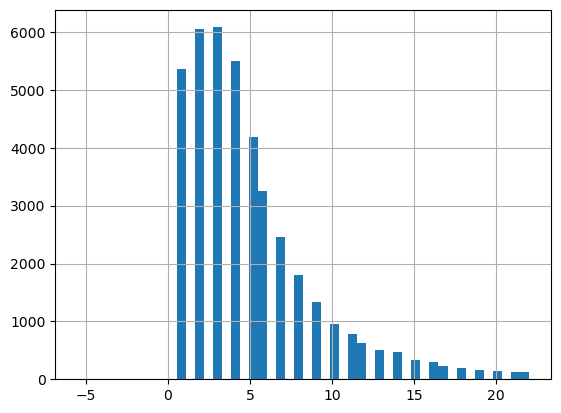

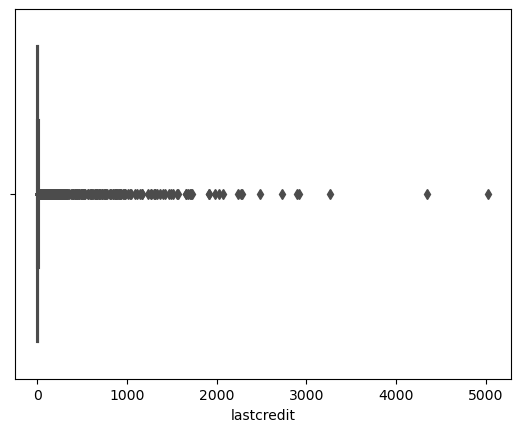

In [48]:
# посмотрим на распределение температур
boxprint(df_credit['lastcredit'], 50)

Подовляющее большинсво клиентов обращается повторно за займом спустя 7 дней после получения займа. Вероятнее всего это разряд клиентов, которые постоянно пользуются займами И берут новый чтобы закрыть предыдуй в льготные период.
Чтобы модель лучше работала можно удалить данные клиентов которые никогда не пользовались микрозаймами

In [49]:
# удалим выбросы
df_credit = df_credit.query('lastcredit <= 10')

count    36973.000000
mean         4.091229
std          2.405609
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         10.000000
Name: lastcredit, dtype: float64


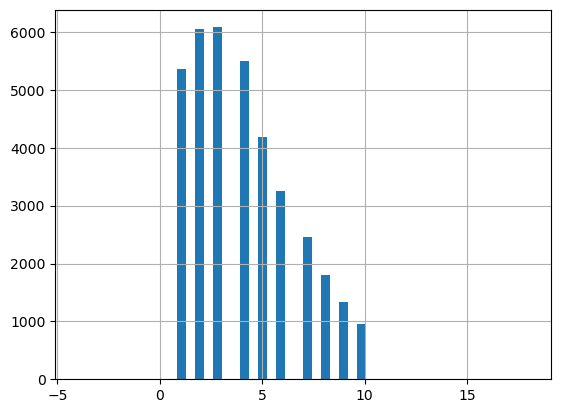

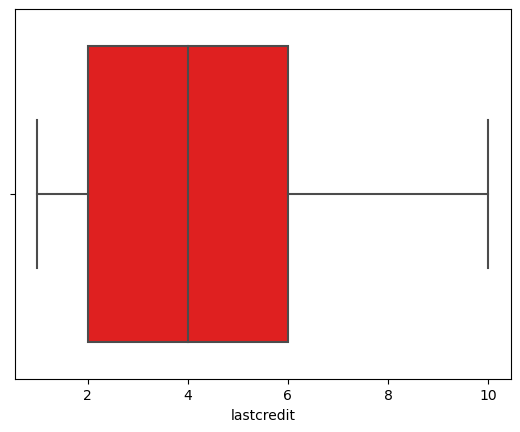

In [50]:
# посмотрим на распределение температур
boxprint(df_credit['lastcredit'], 50)

In [51]:
df_credit = df_credit.drop(['Unnamed: 0',], axis=1)
df_reject = df_reject.drop(['Unnamed: 0',], axis=1)

In [64]:
df_reject = df_reject.values

In [15]:
# разбиение на подвыборки для кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=2308)

In [16]:
# разделение на обучающие признаки и целевой
df_train, df_valid = train_test_split(df_credit, test_size=0.20, random_state=12345)

features_train = df_train.drop(['target'], axis=1).values
target_train = df_train['target'].values

features_valid = df_valid.drop(['target'], axis=1).values
target_valid = df_valid['target'].values

In [17]:
# проверка сбалансированности
df_credit['target'].value_counts(normalize= True) 

0.0    0.729641
1.0    0.270359
Name: target, dtype: float64

In [18]:
df_credit.describe(include = "all")

,age,lastcredit,time_to_lastcredit_closeddt,close_loan_median,open_loan_median,is_active_100,isnt_active_100,micro_loans_active_100,is_active_12,open_sum_12,...,is_type_micro_3,is_active_type_credit_card_3,is_active_type_consumer_3,is_active_type_micro_3,is_type_credit_card_1,is_type_micro_1,is_active_type_micro_1,overall_worst_overdue_state_12,ratio_sum_outstanding_to_open_sum,target
count,36973.000000,36973.000000,36973.000000,36973.000000,36973.000000,36973.000000,36973.000000,3.697300e+04,36973.000000,3.697300e+04,...,36973.000000,36973.000000,36973.000000,36973.000000,36973.000000,36973.000000,36973.000000,36973.000000,36973.000000,36973.000000
mean,34.731723,4.091229,51.639007,0.223176,118.078611,21.729478,60.826441,2.913359e+05,19.317421,4.673617e+05,...,41.277527,0.139697,0.200444,16.332351,0.033754,18.444865,11.818354,105.434290,0.024450,0.270359
std,8.804680,2.405609,1506.564012,12.062603,2005.092780,14.095452,97.134243,2.602913e+05,12.899881,7.859060e+05,...,35.889354,0.513042,0.562292,11.107164,0.262823,16.194636,8.452466,36.947015,1.420071,0.444151
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-82.112200,0.000000
25%,28.000000,2.000000,0.000000,0.000000,1.000000,12.000000,18.000000,1.207000e+05,11.000000,1.487250e+05,...,18.000000,0.000000,0.000000,9.000000,0.000000,8.000000,6.000000,120.000000,0.000000,0.000000
50%,33.000000,4.000000,0.000000,0.000000,2.000000,20.000000,37.000000,2.317670e+05,17.000000,2.952270e+05,...,33.000000,0.000000,0.000000,15.000000,0.000000,14.000000,10.000000,120.000000,0.000000,0.000000
75%,39.000000,6.000000,0.000000,0.000000,4.000000,28.000000,72.000000,3.813650e+05,25.000000,5.198610e+05,...,53.000000,0.000000,0.000000,21.000000,0.000000,23.000000,15.000000,120.000000,0.021263,1.000000
max,75.000000,10.000000,44785.000000,1428.500000,44748.000000,153.000000,6743.000000,5.516940e+06,141.000000,3.123469e+07,...,651.000000,9.000000,16.000000,123.000000,12.000000,334.000000,84.000000,120.000000,106.041667,1.000000


## 3. Обучение модели. <a class="anchor" id="step3"></a>

### 3.1. XGBClassifier<a class="anchor" id="step3.1"></a>

In [ ]:
# подбор параметров
parameters = {'n_estimators': np.arange(44,45,1),
              'max_depth': np.arange(8, 10, 1),
              'min_child_weight': [6, 7],
              'gamma': [0, 1, 5],
              'learning_rate': [0.01]
              }

gs = GridSearchCV(XGBClassifier(random_state=12345), 
                  parameters,
                  cv=kf,
                  scoring='roc_auc')

# обучение
gs.fit(features_train, target_train)

# просмотр лучших параметров
display(gs.best_params_)

# лучший результат
display(gs.best_score_)

In [34]:
model_xgb = (XGBClassifier(max_depth=9,
                           n_estimators=44,
                           booster='dart',
                           random_state=12345,
                          min_child_weight = 6)
             .fit(features_train, target_train))

score_xgb = cross_val_score(model_xgb, features_train, target_train, cv=kf, scoring='roc_auc').mean()
score_xgb_test = cross_val_score(model_xgb, features_valid, target_valid, cv=kf, scoring='roc_auc').mean()

print('Cross-validation train', score_xgb)
print('Cross-validation test', score_xgb_test)

Cross-validation train 0.6165866913768896
Cross-validation test 0.601623754643661


### 3.2. RandomForestClassifier<a class="anchor" id="step3.2"></a>

In [ ]:
# проведем перебор параметров и обучение модели с помледующей проверкой результатов
for estim in range(34, 40):
    model_RandomForest = RandomForestClassifier(random_state=12345, max_depth=21, n_estimators=estim)
    model_RandomForest.fit(features_train, target_train)       
    predictions = model_RandomForest.predict(features_train)
    scores = cross_val_score(model_RandomForest, features_train, target_train, cv=kf, scoring='roc_auc').mean()   
    print("n_estimators =", estim, ": ")
    print("Результат проверки на обучающей  выборке", roc_auc_score(target_train, predictions))
    predictions = model_RandomForest.predict(features_valid)
    print("Результат проверки на валидационной выборке", roc_auc_score(target_valid, predictions))
    print("Результат проверки при кросс-валидации", scores)
    print()

In [30]:
# обучение модели и проверка на валидационной выбоки на сбалансированных данных
model_RandomForest = RandomForestClassifier(random_state=12345,
                                            max_depth=9, 
                                            n_estimators=49)
model_RandomForest.fit(features_train, target_train)       
predictions = model_RandomForest.predict(features_train)
predicted_valid = model_RandomForest.predict(features_valid)

probabilities_valid = model_RandomForest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC ROC:", roc_auc_score(target_valid, probabilities_one_valid))

AUC ROC: 0.6426372553598955


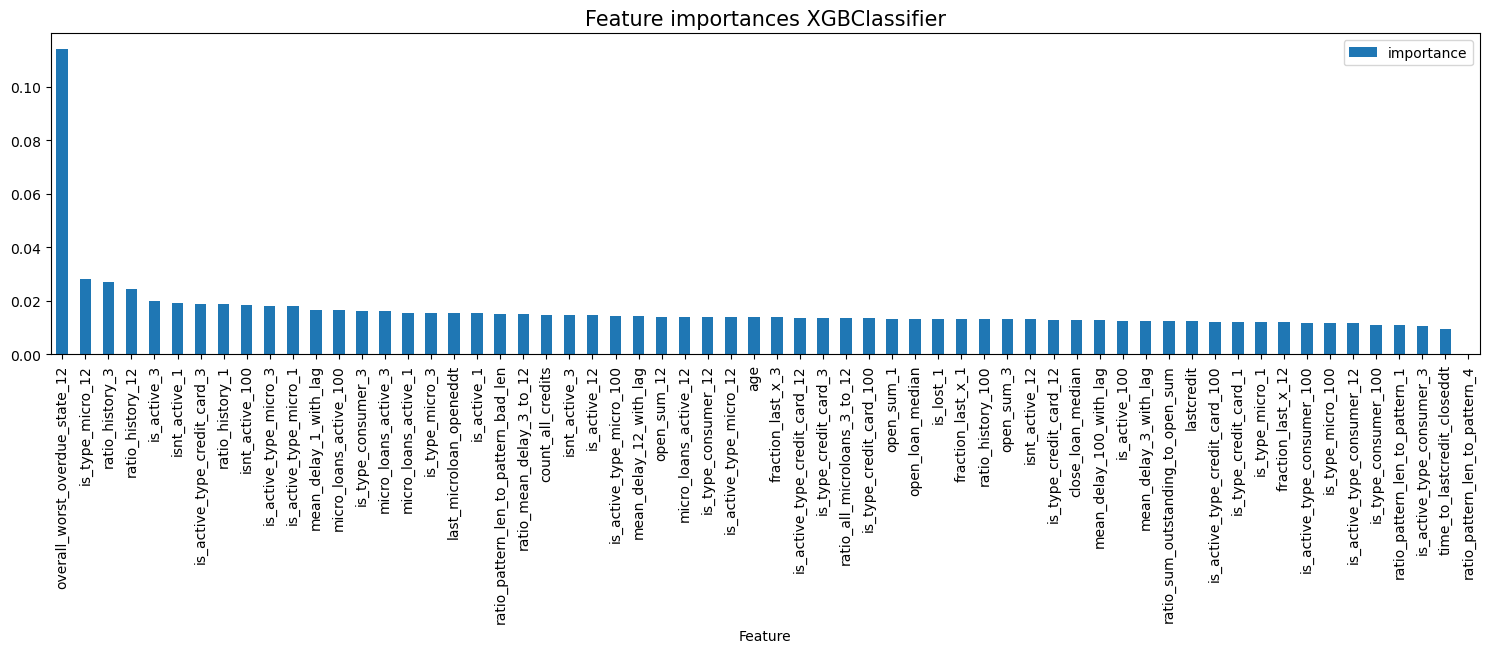

In [31]:
features = df_train.drop(['target'], axis=1)
importanc_xgb = (pd.DataFrame({'feature': features.columns, 'importance': model_xgb.feature_importances_})
             .sort_values(by='importance', ascending=False)
            .reset_index()
            )

              
plt.figure(figsize=(15, 10))

plt.subplot(211)           
importanc_xgb.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), sharex=False)
plt.xlabel('Feature')
plt.title('Feature importances XGBClassifier', fontsize=15)

plt.tight_layout()

In [75]:
y_pred=model_xgb.predict_proba(df_reject).T[1]
y_pred

array([0.05182544, 0.10452154, 0.17183526, ..., 0.39813524, 0.04434671,
       0.4615706 ], dtype=float32)

In [84]:
result = model_xgb.predict(df_reject)
res_proba = pd.DataFrame({'target': result,
                          'Вероятность_банкротсва': y_pred
                          })
display(res_proba.head(5))
# проверка результатов
display(res_proba['target'].value_counts(normalize= True))

,target,Вероятность_банкротсва
0,0,0.051825
1,0,0.104522
2,0,0.171835
3,0,0.096684
4,0,0.243016


0    0.92646
1    0.07354
Name: target, dtype: float64